In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

sys.path.append("..")
from musiclearn import config, processing, vae_models, plotting

In [2]:
exp_name = "mtvae"

## Metrics

(from Yang and Lerch 2020)

Pitch-based metrics:

- Pitch count
- Pitch class histogram
- Pitch class transition matrix
- Pitch range
- Average pitch interval

By calculating these metrics for the source music and the generated music
we can make quantitative comparisons between them to assess generation quality.

First collect the original input data

In [3]:
x = processing.get_string_quartets(4)


Then collect the generated music (interpolations).
If the .npz files don't exist, first run `python string_quartet_inference.py`
to create them.

In [4]:
outputs_dir = Path("../outputs") / exp_name
npzs = list(outputs_dir.rglob("*.npz"))
npz_files = [np.load(npz) for npz in npzs]
xgen = np.vstack([np.concatenate([np.concatenate([v for k, v in f.items()])]) for f in npz_files])

In [5]:
def to_pandas(arr):
    arr = processing.split_array(arr, 4, 4)
    df = pd.DataFrame(
        arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2]), columns=plotting.TRACKS
    )
    df["sample"] = np.divmod(np.arange(len(df)), 16)[0]
    return df

In [6]:
x = to_pandas(x)
xgen = to_pandas(xgen)


## Pitch count

In [7]:
def pitch_count(df):
    df = (
        pd.melt(df, id_vars=["sample"])
        .replace(processing.REST, np.nan)
        .replace(processing.SUSTAIN, np.nan)[["sample", "value"]]
        .groupby("sample")
        .nunique()
        .reset_index()["value"]
    )
    return df.loc[df != 0]


pc_x = pitch_count(x)
pc_xgen = pitch_count(xgen)

<AxesSubplot:xlabel='value', ylabel='Density'>

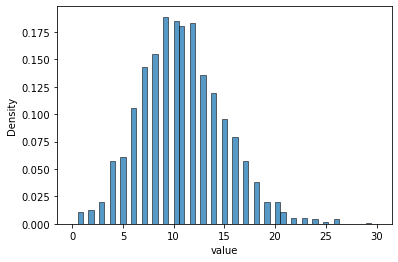

In [8]:
FIGURES = Path("../papers/final/alex/figures/")
sns.histplot(pc_x, stat="density", binrange=(0, 30))

<AxesSubplot:xlabel='value', ylabel='Density'>

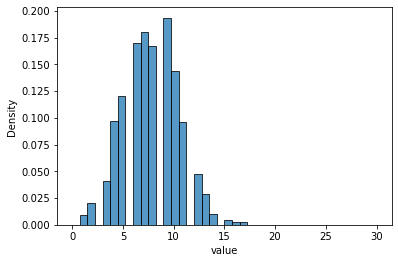

In [9]:
sns.histplot(pc_xgen, stat="density", binrange=(0, 30))


## Pitch Class Histogram

In [10]:
def pitch_count_histogram(df):
    df = (
        pd.melt(df, id_vars=["sample"])
        .replace(processing.REST, np.nan)
        .replace(processing.SUSTAIN, np.nan)[["sample", "value"]]
    )
    df["value"] = df["value"] % 12
    df = df.groupby(["value"]).count().reset_index()
    df["sample"] = df["sample"] / df["sample"].sum()
    return df

In [11]:
pch_x = pitch_count_histogram(x)
pch_xgen = pitch_count_histogram(xgen)

<AxesSubplot:xlabel='note', ylabel='value'>

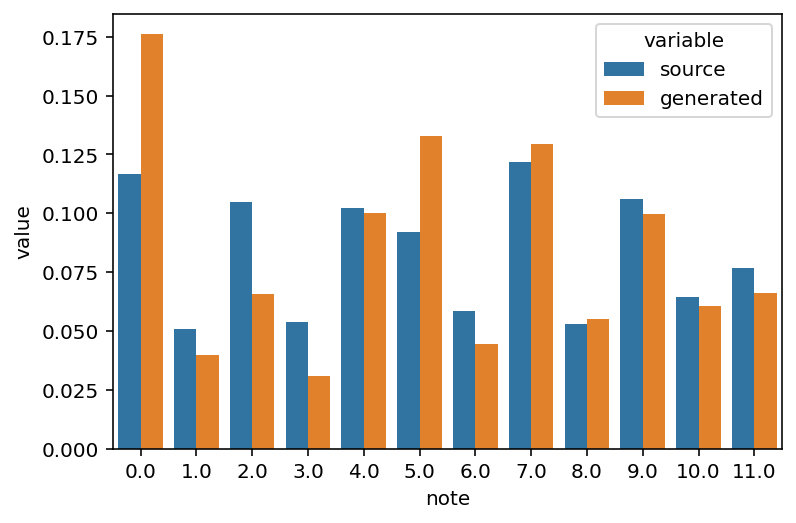

In [12]:
pch = pd.DataFrame(dict(note=pch_x["value"], source=pch_x["sample"], generated=pch_xgen["sample"]))
pch = pd.melt(pch, id_vars="note")
sns.barplot(data=pch, x="note", y="value", hue="variable")


## Pitch class transition matrix

In [13]:
def pitch_class_transitions(df):
    df = df.replace(processing.REST, np.nan).replace(processing.SUSTAIN, np.nan)
    matrix = []
    for colname in plotting.TRACKS:
        col = df[colname].dropna() % 12
        colshift = col.shift(-1)
        counts = pd.DataFrame(dict(track=colname, from_note=col, to_note=colshift, ct=1))
        matrix.append(counts)
    matrix = pd.concat(matrix)
    matrix = matrix.groupby(["from_note", "to_note"]).sum().reset_index()
    matrix["prop"] = matrix["ct"] / matrix["ct"].sum()
    return pd.pivot(matrix, index="from_note", columns="to_note", values="prop")

In [14]:
pctm_x = pitch_class_transitions(x)
pctm_xgen = pitch_class_transitions(xgen)

<AxesSubplot:xlabel='to_note', ylabel='from_note'>

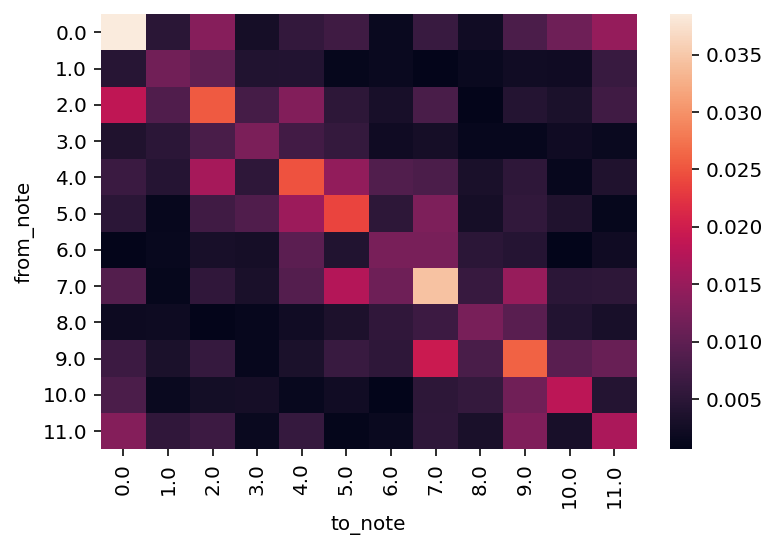

In [15]:
sns.heatmap(pctm_x)

<AxesSubplot:xlabel='to_note', ylabel='from_note'>

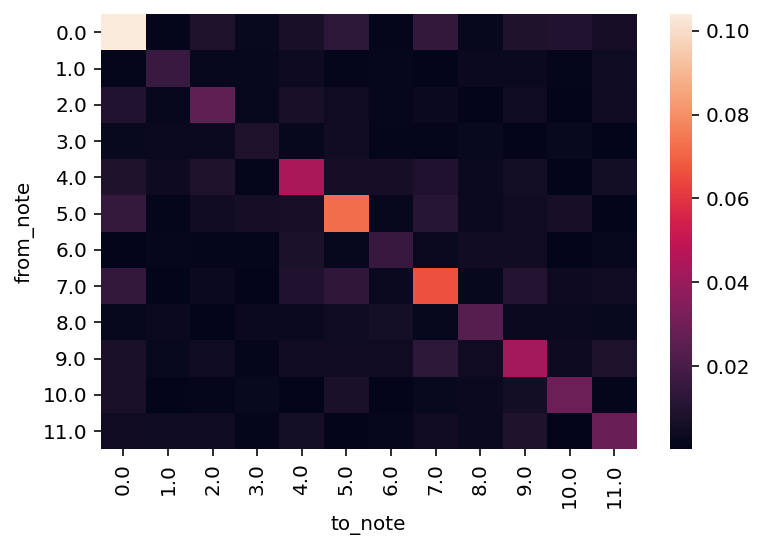

In [16]:
sns.heatmap(pctm_xgen)


## Pitch range

In [17]:
def pitch_range(df):
    df = (
        pd.melt(df, id_vars=["sample"])
        .replace(processing.REST, np.nan)
        .replace(processing.SUSTAIN, np.nan)[["sample", "value"]]
    )
    df = df.groupby(["sample"])["value"].agg(["min", "max"])
    df["pitch_range"] = df["max"] - df["min"]
    return df["pitch_range"].dropna()

In [18]:
pr_x = pitch_range(x)
pr_xgen = pitch_range(xgen)

<AxesSubplot:xlabel='pitch_range', ylabel='Density'>

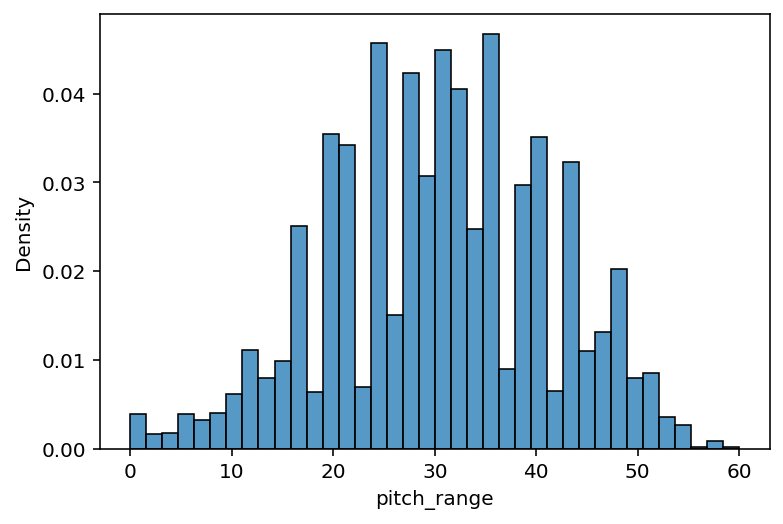

In [19]:
sns.histplot(pr_x, stat="density", binrange=(0, 60))

<AxesSubplot:xlabel='pitch_range', ylabel='Density'>

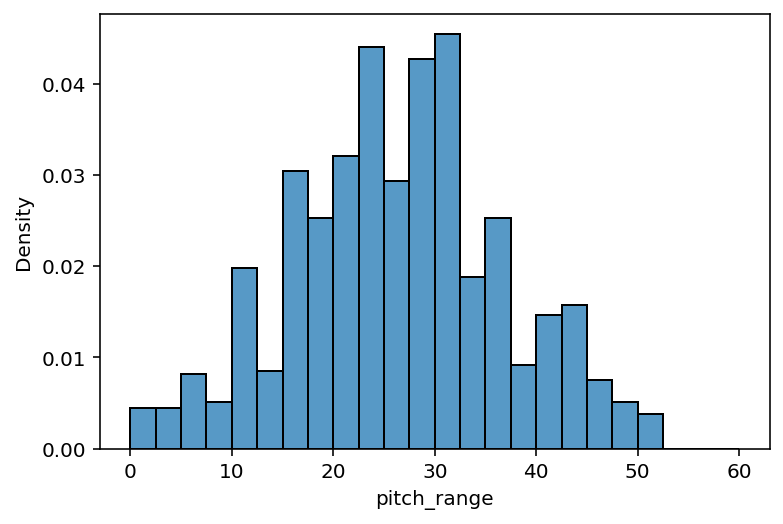

In [20]:
sns.histplot(pr_xgen, stat="density", binrange=(0, 60))


## Average pitch interval

In [21]:
def avg_pitch_interval(df):
    df = df.replace(processing.REST, np.nan).replace(processing.SUSTAIN, np.nan)
    intervals = []
    for colname in plotting.TRACKS:
        col = df[["sample", colname]].dropna()
        colshift = col[colname].shift(-1)
        col["inter"] = colshift - col[colname]
        intervals.append(col[["sample", "inter"]])
    intervals = pd.concat(intervals)
    return intervals.groupby("sample").mean()

In [22]:
api_x = avg_pitch_interval(x)
api_xgen = avg_pitch_interval(xgen)

<AxesSubplot:ylabel='Density'>

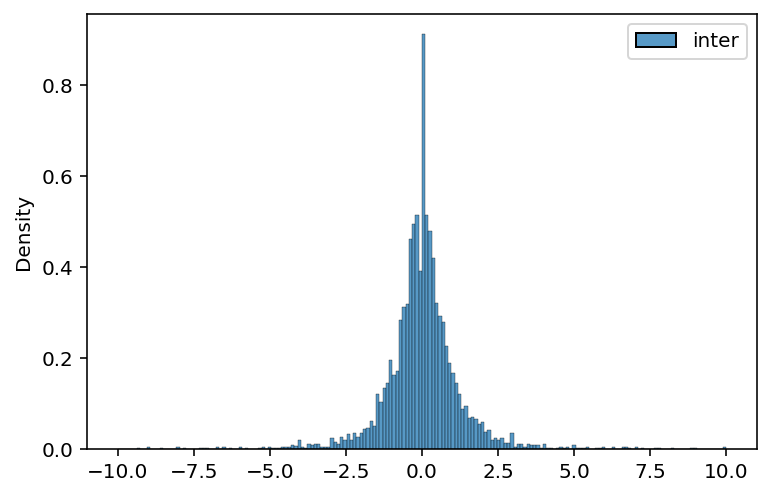

In [23]:
sns.histplot(api_x, stat="density", binrange=(-10, 10))

<AxesSubplot:ylabel='Density'>

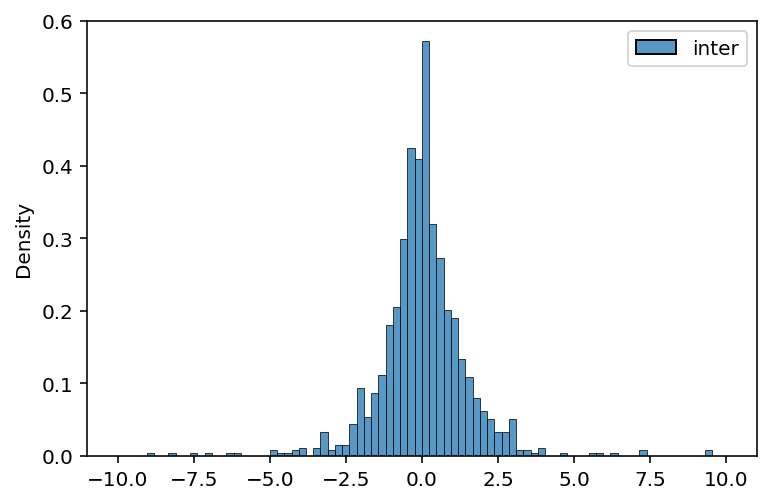

In [24]:
sns.histplot(api_xgen, stat="density", binrange=(-10, 10))